In [1]:
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import ipyvolume as ipv
from ipywidgets import HBox

In [2]:
# Start time.
start_time = time.time()

# Random seed.
#random_seed = np.mod(1e7 * start_time, np.iinfo(np.uint32).max)
#random_seed = np.uint32(random_seed)
#np.random.seed(random_seed)  
random_seed = np.random.seed(np.uint32(1))

# Structure size.
number_of_voxels = 192

# Parameters of the GRF.
ax = 0.5
ay = 0.5
az = 0.5

k = 1.50
n = 1.00
l = 2.00

#period
d = 10

# Porosity of the binary structure.
epsilon1 = 0.360
epsilon2 = 0.670

# Fourier space grid.
xx = np.arange(-number_of_voxels / 2, number_of_voxels / 2)
X, Y, Z = np.meshgrid(xx, xx, xx, copy = True, indexing = 'ij')

# White noise.
B = np.random.randn(number_of_voxels, number_of_voxels, number_of_voxels)

# Fourier transform of the white noise.
A = np.fft.fftn(B)

# Spectral density of the covariance function.
GAMMA = ( 1 + ( np.abs(ax * X) ** (2 * k) + np.abs(ay * Y) ** (2 * k) + np.abs(az * Z) ** (2 * k) ) ** l  ) ** (-n)
#GAMMA =  (np.sinc(ax * X)  * np.sinc(ay * Y) * np.sinc(az * Z)) ** (2)
#GAMMA = (1 + (np.abs(((ax*(X+Y))%(2*d)-d)-d) ** (2 * k) + np.abs(((ay*(Y+Z))%(2*d)-d)-d) ** (2 * k) + np.abs(((az*(Z+X))%(2*d)-d)-d) ** (2 * k) ) ** l) ** (-n)

# Generate GRF from the white noise and covariance function.
A = A * (GAMMA ** (1 / 2))
GRF = np.fft.ifftn(np.fft.fftshift(A))

# Convert GRF to real part (imaginary part is zero anyway except for rounding errors).
GRF = np.real(GRF)

# Threshold to obtain prescribed porosity.
T1 = np.percentile(GRF, 100 * epsilon1)
T2 = np.percentile(GRF, 100 * epsilon2)
#BW = GRF >= T
#BW = GRF
BW = np.zeros((number_of_voxels, number_of_voxels, number_of_voxels))
BW[GRF <= T1] = 15
BW[GRF >= T2] = 30

# Plot a slice of the binary structure.
#imgplot = plt.imshow(BW[:, :, 0])
#plt.show()

In [3]:
C = np.fft.fftn(BW)
C = np.fft.fftshift(C)
#ipv.quickvolshow(np.log(np.abs(C)))

In [4]:
HBox([ipv.quickvolshow(BW,level=[0.7, 0.4, 0.9], opacity=[0.01, 0.05, 0.1]), ipv.quickvolshow(np.log(np.abs(C)), level=[0.7, 0.8, 0.7], opacity=[0.1, 0.1, 0.1])])

C:\ProgramData\Anaconda3\lib\site-packages\ipyvolume\serialize.py:92: RuntimeWarning: invalid value encountered in true_divide
  gradient = gradient / np.sqrt(gradient[0] ** 2 + gradient[1] ** 2 + gradient[2] ** 2)


<function matplotlib.pyplot.show(*args, **kw)>

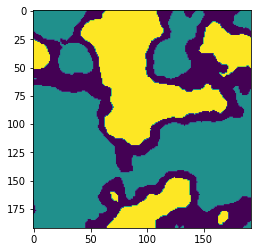

In [5]:
plt.imshow(np.abs(BW[93,:,:]))
plt.show

In [8]:
#spatial step in real space, assume the unit is nanometer
spatial_step = 0.5
#wavevector along X
qx = 2*np.pi*np.fft.fftfreq(len(BW), d = spatial_step)
qx = np.fft.fftshift(qx)

#new q matrix in 3D reciprocal space
QX, QY, QZ = np.meshgrid(qx, qx, qx, sparse=True)

#covert cartesian to spherical coordination
q = np.sqrt(QX**2+ QY**2 +QZ**2)

#bin q into 1D via histogram
hist, bin_edges = np.histogram(q, bins= 80) #range = (min, max)

#calculate the mean value at this binned section
qAxis = (bin_edges[1:] + bin_edges[:-1]) / 2.0

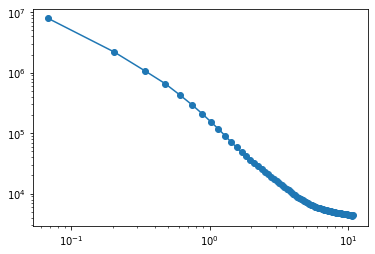

In [9]:
#get the "scattering" profile of the GRF with porosity threthold by taking the weighted histogram of FFT
Int, bin_number = np.histogram(q, bins = 80, weights=np.abs(C)) #range = (min, max)

#normalize Intensity to binning number (hist) of q to get 1D
I = Int/hist

plt.loglog(qAxis, I, 'o-')
plt.show()
